# Setup

# 🛠️ Configuración del Entorno y Observabilidad

En esta primera fase, preparamos el entorno de ejecución instalando las librerías orquestadoras (`LangChain`, `LangGraph`) y los SDKs de Google Gemini.

Un punto crítico en este proyecto es la **Observabilidad**. Utilizamos **Weave (de Weights & Biases)** para rastrear la ejecución del agente. Esto nos permite auditar:
1.  La latencia de cada llamada a la IA.
2.  Los costos de tokens.
3.  La traza exacta de cómo el agente tomó decisiones (Input -> Router -> Acción -> Output).

In [ ]:
# Instalamos LangChain, el SDK de Google, LangGraph y la herramienta experimental de Python, Pydantic y Weave
!pip install -q -U google-genai langchain langchain-google-genai langgraph langchain-experimental pydantic weave

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.4/703.4 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.6/463.6 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.0 MB/s eta 0:00:00
   ━━━━

In [ ]:
import os
import sys
import json
import time
from google import genai
from google.colab import userdata
import weave

import base64
from PIL import Image
import io

# Aseguramos que langchain_core esté actualizado para manejar mensajes multimodales
from langchain_core.messages import HumanMessage


# Configuración de Seguridad para API KEYS
try:
    # Aseguramos tener el secreto 'GOOGLE_API_KEY' configurado en Colab
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEYL')
except Exception as e:
    print("⚠️ Error: No se encontró la GOOGLE_API_KEY en los secretos de Colab.")
    print("Por favor, agrégala en el ícono de la llavecita a la izquierda.")

client = genai.Client(api_key=GOOGLE_API_KEY)

from enum import Enum, auto
from typing import Optional, Dict
from typing import Literal, List
from typing import Union, List, Any
from google.genai import types

# Importaciones de LangChain y Tipos
from typing import TypedDict, Literal, Optional
from langchain_google_genai import ChatGoogleGenerativeAI
#from langchain_core.tools import tool
#from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent

# Importación de la herramienta de ejecución de código
from langchain_experimental.utilities import PythonREPL

print("✅ Librerías importadas y entorno configurado.")

✅ Librerías importadas y entorno configurado.


In [ ]:
# Inicialización del Proyecto
# Esto activa la captura automática de LangChain/LangGraph
weave.init("agente_tutor_python")
print("✅ Weave inicializado y rastreando.")

weave: Please login to Weights & Biases (https://wandb.ai) to continue...
wandb: WARNING The anonymous parameter to wandb.login() has no effect and will be removed in future versions.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=weave
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: leanai (teamlg-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
weave: Logged in as Weights & Biases user: leanai.
weave: View Weave data at https://wandb.ai/teamlg-ai/agente_tutor_python/weave


✅ Weave inicializado y rastreando.


In [ ]:
# Modelos disponibles en Gemini
print("List of models that support generateContent:\n")
for m in client.models.list():
    for action in m.supported_actions:
        if action == "generateContent":
            print(m.name)

List of models that support generateContent:

models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image-preview
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-pro-image-preview
models/nano-banana-pro-preview
models/gemini-robotics-er-1.5-preview
models/gemini-2.5-c

# 🧠 Fase 1: Estructuración y Modelos

Para construir un sistema robusto, no podemos depender de texto libre. Aquí definimos la "columna vertebral" del agente:

1.  **Tipado Estricto (Pydantic):** Definimos `RouterOutput` y una lista literal de módulos (`LISTA_MODULOS`). Esto obliga al LLM a devolver una clasificación exacta, evitando alucinaciones sobre temas que no están en el programa de estudio.
2.  **Configuración de Modelos:** Utilizamos **Gemini 2.5 Flash** por su baja latencia y capacidad multimodal. Configuramos `temperature=0` para garantizar determinismo en la generación de código Python.

In [ ]:
# --- 1. Definición de Módulos del Programa (Pydantic) ---
# Esto garantiza que el agente SOLO clasifique dentro de tu temario.

LISTA_MODULOS = Literal[
    "Primeros pasos en Python",
    "Tipos de datos, variables y operadores",
    "Sentencias de control - PARTE 1: Estructura condicional",
    "Sentencias de control - PARTE 2: Estructuras repetitivas",
    "Sentencias de control - PARTE 3: Estructuras anidadas",
    "Colecciones - PARTE 1: Listas",
    "Colecciones - PARTE 2: Tuplas",
    "Colecciones - PARTE 3: String",
    "Colecciones - PARTE 4: Diccionarios",
    "Colecciones - PARTE 5: Integrando colecciones",
    "Funciones y Archivos - PARTE 1: FUNCIONES",
    "Funciones y Archivos - PARTE 2: ARCHIVOS"
]

class RouterOutput(BaseModel):
    """Estructura obligatoria para la salida del nodo clasificador."""
    tipo_tarea: Literal["TEORIA", "PRACTICA"] = Field(
        ..., description="Si el usuario pide una explicación (TEORIA) o código/ejercicio (PRACTICA)"
    )
    modulo: LISTA_MODULOS = Field(
        ..., description="El módulo específico de la materia al que corresponde la consulta."
    )
    razonamiento: str = Field(..., description="Breve explicación de por qué se clasificó así.")

# --- 2. Inicialización de Modelos IA ---

# Modelo "Gemini 2.5" (Usamos Flash para código rápido/práctica)
llm_gemini_2_5 = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0, # Temperatura 0 es crucial para generar código preciso
    google_api_key=GOOGLE_API_KEY
)

# Modelo especializado para el Router (Salida Estructurada)
llm_router = llm_gemini_2_5.with_structured_output(RouterOutput)

# --- 3. Inicialización de Herramienta Python ---
python_repl = PythonREPL()

print("✅ Modelos y REPL listos.")

✅ Modelos y REPL listos.


# ⚙️ Fase 2: Arquitectura del Grafo (LangGraph)

Esta es la lógica central del sistema. Diseñamos un **Grafo de Estados (StateGraph)** donde cada función es un nodo que realiza una tarea específica y pasa el resultado al estado compartido (`AgentState`).

### Componentes Clave:
* **Memoria Compartida:** Un diccionario tipado que viaja a través del grafo almacenando el input del usuario, la imagen (si existe) y el código generado.
* **Nodo Router (Multimodal):** Capaz de "ver" imágenes y leer texto para decidir si el problema es Teórico o Práctico.
* **Nodo Ejecutor (Sandbox):** Utilizamos `PythonREPL` de `langchain_experimental`. Esto permite que el agente no solo escriba código, sino que **lo ejecute** para validar que funciona antes de responder.
* **Decoradores `@weave.op()`:** Instrumentamos cada función para que aparezca visualmente en el dashboard de trazas.

In [ ]:
# --- 1. Estado del Agente (Memoria Compartida) ---
class AgentState(TypedDict):
    input_usuario: str
    input_imagen: Optional[str] # URL o path de la imagen (si aplica)

    # Datos internos
    clasificacion: Optional[RouterOutput]
    codigo_generado: Optional[str]
    resultado_ejecucion: Optional[str]

    # Salida Final
    respuesta_final: str

# --- 2. Definición de Nodos (Funciones) ---

def codificar_imagen(image_path: str) -> str:
    """
    Lee una imagen desde una ruta local y la convierte a string Base64.
    """
    try:
        with open(image_path, "rb") as image_file:
            # Leemos el binario y lo codificamos
            encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
        return encoded_string
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

@weave.op()
def nodo_clasificador(state: AgentState):
    """Identifica el módulo y si es teoría o práctica (Versión Multimodal)."""
    print(f"--- 🧠 ROUTER: Analizando Input (Multimodal) ---")

    # 1. Preparamos el contenido base (Texto)
    contenido_mensaje = [
        {
            "type": "text",
            "text": f"Analiza la entrada del usuario. Clasifícala en uno de los módulos del programa de Python. Entrada texto: {state['input_usuario']}"
        }
    ]

    # 2. Si hay imagen, la agregamos al payload
    imagen_b64 = state.get('input_imagen')
    if imagen_b64:
        print("   👀 Imagen detectada, adjuntando al prompt...")
        contenido_mensaje.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{imagen_b64}"},
        })

    # 3. Creamos el mensaje compatible con LangChain/Gemini
    mensaje_multimodal = HumanMessage(content=contenido_mensaje)

    # 4. Invocamos al modelo con estructura
    # Nota: Pasamos una lista de mensajes [mensaje_multimodal]
    decision = llm_router.invoke([mensaje_multimodal])

    return {"clasificacion": decision}

@weave.op()
def nodo_teoria(state: AgentState):
    """Resuelve preguntas teóricas usando 'Gemini 2.5' viendo la imagen si existe."""
    data = state['clasificacion']
    print(f"--- 📚 EXPERTO TEÓRICO: Explicando {data.modulo} ---")

    texto_prompt = f"""
    Actúa como un profesor experto en Python.
    Módulo actual: {data.modulo}.
    Pregunta del alumno: {state['input_usuario']}

    Si hay una imagen, úsala como referencia para tu explicación.

    Provee una explicación teórica clara, concisa y con ejemplos conceptuales.
    """

    contenido_mensaje = [{"type": "text", "text": texto_prompt}]

    # Inyectar imagen si existe
    imagen_b64 = state.get('input_imagen')
    if imagen_b64:
        print("   👀 Experto teórico viendo la imagen...")
        contenido_mensaje.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{imagen_b64}"},
        })

    mensaje_multimodal = HumanMessage(content=contenido_mensaje)
    respuesta = llm_gemini_2_5.invoke([mensaje_multimodal])

    return {"respuesta_final": respuesta.content}

@weave.op()
def nodo_programador(state: AgentState):
    """Genera código Python usando 'Gemini 2.5' viendo la imagen si existe."""
    data = state['clasificacion']
    print(f"--- 💻 PROGRAMADOR: Generando código para {data.modulo} ---")

    # 1. Construimos el texto del prompt
    texto_instrucciones = f"""
    Eres un programador experto en asistencia de codificación en Python.
    Tarea: Resolver el ejercicio del módulo '{data.modulo}'.
    Pedido del usuario: {state['input_usuario']}

    Si hay una imagen adjunta, extrae los datos y requisitos visuales de ella escrupulosamente.

    IMPORTANTE:
    1. Escribe SOLO código Python válido.
    2. Usa print() para mostrar los resultados.
    3. NO uses input(), hardcodea variables de prueba con los valores que veas en la imagen.
    4. NO incluyas explicaciones, solo el código.
    """

    # 2. Preparamos el contenido multimodal
    contenido_mensaje = [
        {
            "type": "text",
            "text": texto_instrucciones
        }
    ]

    # 3. Inyectamos la imagen si existe en el estado
    imagen_b64 = state.get('input_imagen')
    if imagen_b64:
        print("   👀 Programador viendo la imagen...")
        contenido_mensaje.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{imagen_b64}"},
        })

    # 4. Invocamos al modelo con la lista de mensajes (HumanMessage)
    mensaje_multimodal = HumanMessage(content=contenido_mensaje)

    # Nota: Pasamos una lista que contiene el mensaje
    respuesta = llm_gemini_2_5.invoke([mensaje_multimodal])

    # Limpieza básica de Markdown
    codigo_limpio = respuesta.content.replace("```python", "").replace("```", "").strip()

    return {"codigo_generado": codigo_limpio}

@weave.op()
def nodo_ejecutor(state: AgentState):
    """Ejecuta el código usando PythonREPL de LangChain."""
    print("--- ⚙️ EJECUTOR: Corriendo script... ---")

    # PAUSA TÁCTICA: Esperamos 2 segundos antes de ejecutar para no saturar la API
    time.sleep(2)

    codigo = state['codigo_generado']

    try:
        # Usamos la herramienta oficial de LangChain
        resultado = python_repl.run(codigo)

        # Si el REPL no devuelve nada (ej: solo definiciones), avisamos
        if not resultado:
            resultado = "(El código se ejecutó sin errores pero no imprimió salida)"

    except Exception as e:
        resultado = f"Error de ejecución: {str(e)}"

    print(f"    ↳ Resultado: {resultado.strip()[:50]}...")
    return {"resultado_ejecucion": resultado}

@weave.op()
def nodo_sintesis(state: AgentState):
    """Combina código y resultado en una respuesta final."""
    print("--- 📝 SINTETIZADOR: Armando respuesta ---")

    # PAUSA TÁCTICA
    time.sleep(2)

    prompt = f"""
    El usuario pidió un ejercicio de práctica sobre: {state['input_usuario']}

    Hemos generado este código Python:
    {state['codigo_generado']}

    Y al ejecutarlo, dio este resultado:
    {state['resultado_ejecucion']}

    Por favor, explica brevemente el código y valida que el resultado sea correcto.
    """
    respuesta = llm_gemini_2_5.invoke(prompt) # Usamos el modelo "inteligente" para explicar
    return {"respuesta_final": respuesta.content}

# --- 3. Construcción del Grafo (LangGraph) ---

workflow = StateGraph(AgentState)

# Agregar nodos
workflow.add_node("router", nodo_clasificador)
workflow.add_node("experto_teoria", nodo_teoria)
workflow.add_node("programador", nodo_programador)
workflow.add_node("ejecutor", nodo_ejecutor)
workflow.add_node("sintetizador", nodo_sintesis)

# Definir punto de entrada
workflow.set_entry_point("router")

# Definir lógica condicional (Conditional Edges)
def decidir_camino(state):
    tipo = state['clasificacion'].tipo_tarea
    if tipo == "TEORIA":
        return "experto_teoria"
    else:
        return "programador"

workflow.add_conditional_edges(
    "router",
    decidir_camino,
    {
        "experto_teoria": "experto_teoria",
        "programador": "programador"
    }
)

# Conectar el resto de nodos
workflow.add_edge("programador", "ejecutor")
workflow.add_edge("ejecutor", "sintetizador")
workflow.add_edge("sintetizador", END)
workflow.add_edge("experto_teoria", END)

# Compilar
app_agente = workflow.compile()

print("✅ Sistema Agentico Compilado y Listo.")

✅ Sistema Agentico Compilado y Listo.


# 🚀 Fase 3: Pruebas de Ejecución

A continuación, sometemos al agente a tres escenarios de prueba para validar su flexibilidad:

1.  **Caso Práctico (Texto):** Solicitud de un script complejo de manipulación de listas.
2.  **Caso Teórico (Texto):** Pregunta conceptual sobre Tuplas vs Listas.
3.  **Caso Multimodal (Imagen + Texto):** El agente debe leer una captura de pantalla de un ejercicio, extraer los datos visuales, escribir el código y resolverlo.

In [ ]:
# --- PRUEBA 1: Caso Práctico ---
input_practico = """
Escribir un script que permita definir la siguiente lista:
lista_Ej2=[21,“Aula”,7.3,230,“clase”,8.75,65,“LECCION”,3.1]. Luego, se pide recuperar y
mostrar con carteles adecuados:
-​ El número 65.
-​ El string “LECCION”.
-​ Los elementos “clase”,8.75.
-​ Todos los strings.
-​ Todos los flotantes.
-​ Todos los enteros.
"""

print(f"\n🚀 INICIANDO PRUEBA PRACTICA: '{input_practico}'\n" + "="*50)

resultado = app_agente.invoke({"input_usuario": input_practico})

print("\n" + "="*50)
print("🤖 RESPUESTA FINAL DEL AGENTE:\n")
print(resultado['respuesta_final'])
print("\n(Código generado internamente:)")
print(resultado['codigo_generado'])



🚀 INICIANDO PRUEBA PRACTICA: '
Escribir un script que permita definir la siguiente lista:
lista_Ej2=[21,“Aula”,7.3,230,“clase”,8.75,65,“LECCION”,3.1]. Luego, se pide recuperar y
mostrar con carteles adecuados:
-​ El número 65.
-​ El string “LECCION”.
-​ Los elementos “clase”,8.75.
-​ Todos los strings.
-​ Todos los flotantes.
-​ Todos los enteros.
'
--- 🧠 ROUTER: Analizando Input (Multimodal) ---


weave: 🍩 https://wandb.ai/teamlg-ai/agente_tutor_python/r/call/019b10cc-a6f4-7c22-8a4f-7a09436a8999


--- 💻 PROGRAMADOR: Generando código para Colecciones - PARTE 1: Listas ---


weave: 🍩 https://wandb.ai/teamlg-ai/agente_tutor_python/r/call/019b10cc-af97-7b19-ab9e-8548816d9629


--- ⚙️ EJECUTOR: Corriendo script... ---


weave: 🍩 https://wandb.ai/teamlg-ai/agente_tutor_python/r/call/019b10cc-bfae-785b-ba6c-a4fd84e59470


    ↳ Resultado: El número 65: 65
El string "LECCION": LECCION
Los ...
--- 📝 SINTETIZADOR: Armando respuesta ---


weave: 🍩 https://wandb.ai/teamlg-ai/agente_tutor_python/r/call/019b10cc-c796-7abd-815e-2d0933d85022



🤖 RESPUESTA FINAL DEL AGENTE:

Aquí tienes la explicación del código y la validación de su resultado:

### Explicación del Código Python:

El script tiene como objetivo principal trabajar con una lista predefinida (`lista_Ej2`) y realizar varias operaciones de recuperación y clasificación de sus elementos.

1.  **Definición de la Lista:**
    ```python
    lista_Ej2 = [21, "Aula", 7.3, 230, "clase", 8.75, 65, "LECCION", 3.1]
    ```
    Se inicializa una lista llamada `lista_Ej2` que contiene una mezcla de números enteros (`int`), cadenas de texto (`str`) y números de punto flotante (`float`).

2.  **Recuperación de Elementos Específicos por Índice:**
    ```python
    print("El número 65:", lista_Ej2[6])
    print("El string \"LECCION\":", lista_Ej2[7])
    print("Los elementos \"clase\", 8.75:", lista_Ej2[4], lista_Ej2[5])
    ```
    *   Python utiliza **indexación basada en cero**, lo que significa que el primer elemento de una lista está en el índice `0`, el segundo en `1`, y así

In [ ]:
# --- PRUEBA 2: Caso Teórico ---
input_teorico = "Explícame qué es una tupla y en qué se diferencia de una lista."

print(f"\n\n🚀 INICIANDO PRUEBA TEÓRICA: '{input_teorico}'\n" + "="*50)
resultado_t = app_agente.invoke({"input_usuario": input_teorico})

print("\n" + "="*50)
print("🤖 RESPUESTA FINAL DEL AGENTE:\n")
print(resultado_t['respuesta_final'])

weave: 🍩 https://wandb.ai/teamlg-ai/agente_tutor_python/r/call/019b10d4-8b8d-725a-8eab-cf7e783b27a8




🚀 INICIANDO PRUEBA TEÓRICA: 'Explícame qué es una tupla y en qué se diferencia de una lista.'
--- 🧠 ROUTER: Analizando Input (Multimodal) ---
--- 📚 EXPERTO TEÓRICO: Explicando Colecciones - PARTE 2: Tuplas ---


weave: 🍩 https://wandb.ai/teamlg-ai/agente_tutor_python/r/call/019b10d4-9459-737b-8108-76f4684bfe64



🤖 RESPUESTA FINAL DEL AGENTE:

¡Hola! ¡Excelente pregunta! La distinción entre tuplas y listas es fundamental para entender cómo trabajar con colecciones de datos en Python de manera eficiente y segura.

No hay una imagen adjunta, así que procederé con la explicación textual, que será muy clara y con ejemplos.

---

### Módulo: Colecciones - PARTE 2: Tuplas
### Tema: ¿Qué es una tupla y en qué se diferencia de una lista?

Vamos a desglosarlo con la precisión que un profesor de Python esperaría.

---

### ¿Qué es una Tupla en Python?

Imagina una tupla como una caja de información que, una vez que la llenas, queda sellada y no puedes cambiar lo que hay dentro.

Formalmente, una `tupla` es una **colección ordenada e inmutable de elementos** en Python.

**Características clave de las Tuplas:**

1.  **Ordenadas (Ordered):** Los elementos tienen un orden definido y este orden no cambia. Puedes acceder a ellos por su índice (posición).
2.  **Inmutables (Immutable):** ¡Esta es la característ

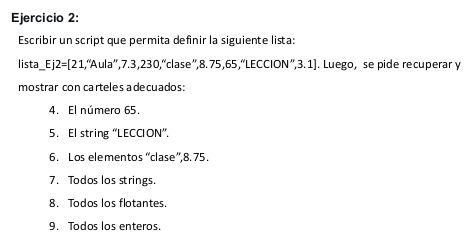

In [ ]:
# Visualizamos la imagen de prueba para la implementación multimodal
image_input = Image.open("/content/Unidad5-ej2.png")
image_input

In [ ]:
# --- PRUEBA 3: Caso Multimodal ---

# 1. Imagen que se subió para el ejemplo multimodal
nombre_archivo_img = "Unidad5-ej2.png"

# Verificamos si existe para evitar errores en la demo
import os
if os.path.exists(nombre_archivo_img):

    # 2. Codificamos la imagen
    imagen_procesada = codificar_imagen(nombre_archivo_img)

    # 3. Input del usuario (puede ser breve porque la imagen tiene el contexto)
    texto_usuario = "Resuelve lo requerido en la imagen adjunta."

    print(f"\n🚀 INICIANDO PRUEBA CON IMAGEN\n" + "="*50)

    # 4. Ejecutamos el agente pasando la imagen codificada
    resultado_img = app_agente.invoke({
        "input_usuario": texto_usuario,
        "input_imagen": imagen_procesada
    })

    print("\n" + "="*50)
    print("🤖 CLASIFICACIÓN DETECTADA:", resultado_img['clasificacion'].modulo)
    print("📝 RESPUESTA FINAL DEL AGENTE:\n")
    print(resultado_img['respuesta_final'])
    print("\n(Código generado internamente:)")
    print(resultado_img['codigo_generado'])

else:
    print(f"⚠️ Por favor sube un archivo llamado '{nombre_archivo_img}' al Colab para probar.")

weave: 🍩 https://wandb.ai/teamlg-ai/agente_tutor_python/r/call/019b10db-f3df-7480-b7d0-d983adb7b4ea



🚀 INICIANDO PRUEBA CON IMAGEN
--- 🧠 ROUTER: Analizando Input (Multimodal) ---
   👀 Imagen detectada, adjuntando al prompt...


weave: 🍩 https://wandb.ai/teamlg-ai/agente_tutor_python/r/call/019b10db-fc53-7e69-bccc-085b22d98c48


--- 💻 PROGRAMADOR: Generando código para Colecciones - PARTE 1: Listas ---
   👀 Programador viendo la imagen...


weave: 🍩 https://wandb.ai/teamlg-ai/agente_tutor_python/r/call/019b10dc-18bd-790e-ac20-070927825fef


--- ⚙️ EJECUTOR: Corriendo script... ---


weave: 🍩 https://wandb.ai/teamlg-ai/agente_tutor_python/r/call/019b10dc-2093-7a6c-84c9-a66bdda55447


    ↳ Resultado: 4. El número 65: 65
5. El string "LECCION": LECCIO...
--- 📝 SINTETIZADOR: Armando respuesta ---

🤖 CLASIFICACIÓN DETECTADA: Colecciones - PARTE 1: Listas
📝 RESPUESTA FINAL DEL AGENTE:

El código Python proporcionado trabaja con una lista heterogénea (`lista_Ej2`) y realiza varias operaciones de acceso y filtrado sobre ella.

### Explicación del Código:

1.  **Inicialización de la lista:**
    *   `lista_Ej2 = [21, "Aula", 7.3, 230, "clase", 8.75, 65, "LECCION", 3.1]`
        *   Se define una lista llamada `lista_Ej2` que contiene una mezcla de números enteros, strings y números flotantes.

2.  **Acceso a elementos individuales por índice:**
    *   `print("4. El número 65:", lista_Ej2[6])`
        *   Accede al elemento en la posición 6 de la lista (recordando que los índices empiezan en 0). El elemento en el índice 6 es el número entero `65`.
    *   `print("5. El string \"LECCION\":", lista_Ej2[7])`
        *   Accede al elemento en la posición 7 de la lista. El ele

# Weave

Comparación de la implementación del Agente

Traces: https://wandb.ai/teamlg-ai/agente_tutor_python/weave/traces?view=traces_2025-12-12_05-41-48-915

# Recursos
* [API de Gemini](https://ai.google.dev/api?hl=es-419)
* [Pydantic](https://docs.pydantic.dev/latest/)
* [LangChain](https://docs.langchain.com/)
* [Weave](https://docs.wandb.ai/weave)